In [51]:
%load_ext autoreload
%autoreload 2

from PIL import Image, ExifTags
from dhdrnet.util import DATA_DIR, ROOT_DIR
from dhdrnet.gen_pairs import GenAllPairs
import exifread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

FIGDIR = ROOT_DIR / "figures"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from more_itertools import sample

dng_sample = sample((DATA_DIR / "dngs").iterdir(), k=1)[0]

f = dng_sample.open('rb')
tags = exifread.process_file(f, details=False)
tags

{'Image SubfileType': (0x00FE) Long=Reduced-resolution image @ 18,
 'Image ImageWidth': (0x0100) Long=640 @ 30,
 'Image ImageLength': (0x0101) Long=474 @ 42,
 'Image BitsPerSample': (0x0102) Short=[8, 8, 8] @ 530,
 'Image Compression': (0x0103) Short=JPEG @ 66,
 'Image PhotometricInterpretation': (0x0106) Short=6 @ 78,
 'Image Make': (0x010F) ASCII=motorola @ 536,
 'Image Model': (0x0110) ASCII=Nexus 6 @ 546,
 'Image StripOffsets': (0x0111) Long=20938 @ 114,
 'Image Orientation': (0x0112) Short=Horizontal (normal) @ 126,
 'Image SamplesPerPixel': (0x0115) Short=3 @ 138,
 'Image RowsPerStrip': (0x0116) Long=474 @ 150,
 'Image StripByteCounts': (0x0117) Long=161125 @ 162,
 'Image PlanarConfiguration': (0x011C) Short=1 @ 174,
 'Image Software': (0x0131) ASCII=HDR+ 1.0.101720515r [burst_process] @ 554,
 'Image DateTime': (0x0132) ASCII=2017:11:02 20:05:13 @ 590,
 'Image Tag 0x014A': (0x014A) Long=1166 @ 210,
 'Image YCbCrCoefficients': (0x0211) Ratio=[299/1000, 587/1000, 57/500] @ 610,
 'I

In [3]:
print(tags["EXIF FNumber"].values[0])
print(tags["EXIF ShutterSpeedValue"].values[0].num)

2
10665799


In [4]:
tags["EXIF ShutterSpeedValue"].values[0].num / tags["EXIF ShutterSpeedValue"].values[0].den

10.665799

In [5]:
def exif(p):
    f = p.open('rb')
    tags = exifread.process_file(f, details=True)
    fn = tags["EXIF FNumber"].values[0].num
    shutter_speed = tags["EXIF ShutterSpeedValue"].values[0].num / tags["EXIF ShutterSpeedValue"].values[0].den

    return np.log2((fn**2)/(shutter_speed))

In [28]:
from dhdrnet.gen_pairs import ev_from_exif

In [7]:
ev_from_exif(dng_sample)

-1.4149201402808362

In [8]:
exif(dng_sample)

-1.4149201402808362

In [9]:
import time

t = time.process_time()
for s in sample((DATA_DIR / "dngs").iterdir(), k=100):
    exif(s)
elapsed = time.process_time() - t
print(f"average time for naive exif = {elapsed / 100}")

average time for naive exif = 0.0007767372099999981


In [10]:
t = time.process_time()
for s in sample((DATA_DIR / "dngs").iterdir(), k=100):
    ev_from_exif(s)
elapsed = time.process_time() - t
print(f"average time for smarter? exif = {elapsed / 100}")

average time for smarter? exif = 0.0007852138900000006


In [11]:
all_evs = {d: ev_from_exif(d) for d in (DATA_DIR/"dngs").iterdir()}

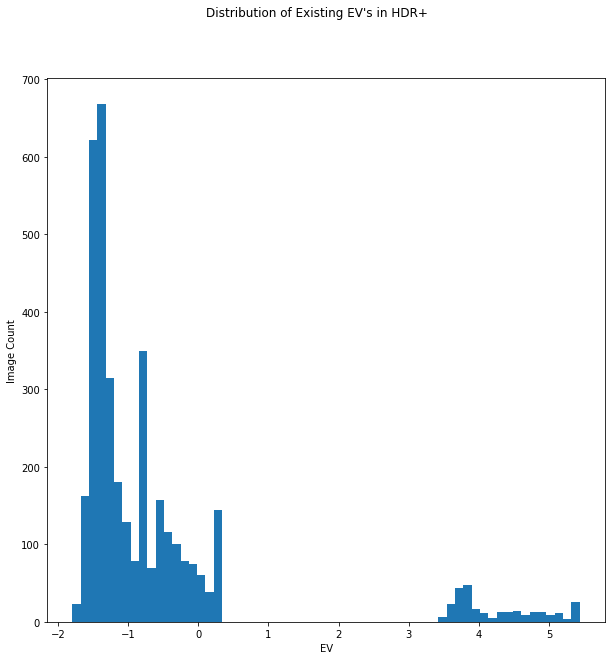

In [53]:
fig = plt.figure(figsize=(10,10))
plt.hist(all_evs.values(), bins='auto')
plt.suptitle("Distribution of Existing EV's in HDR+")
plt.xlabel("EV")
plt.ylabel("Image Count")
fig.savefig(FIGDIR/"BaseEVDist.png")

get a bunch of low ev images

In [54]:
low_evs = {k: v for k,v in all_evs.items() if v < -1}
low_sample = sample(low_evs.items(),k=15)
im_sample = sample(all_evs.items(),k=10)
print(len(low_evs))
print(len(low_sample))

2057
15


<Figure size 432x288 with 0 Axes>

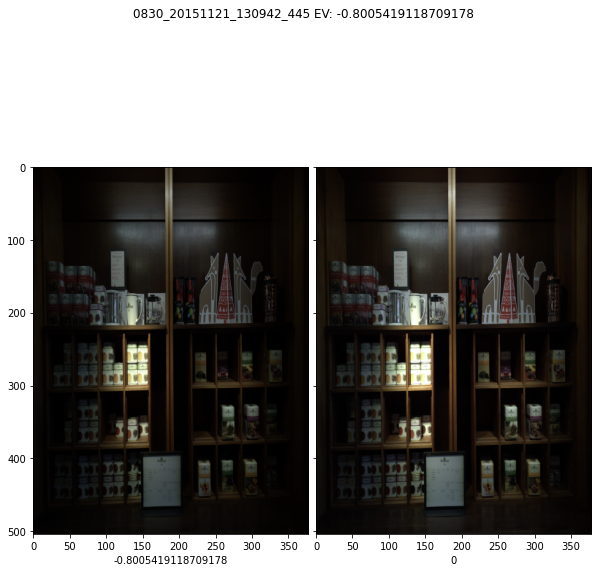

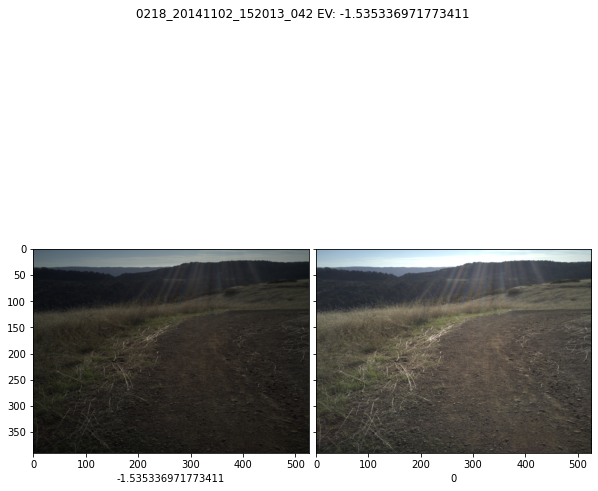

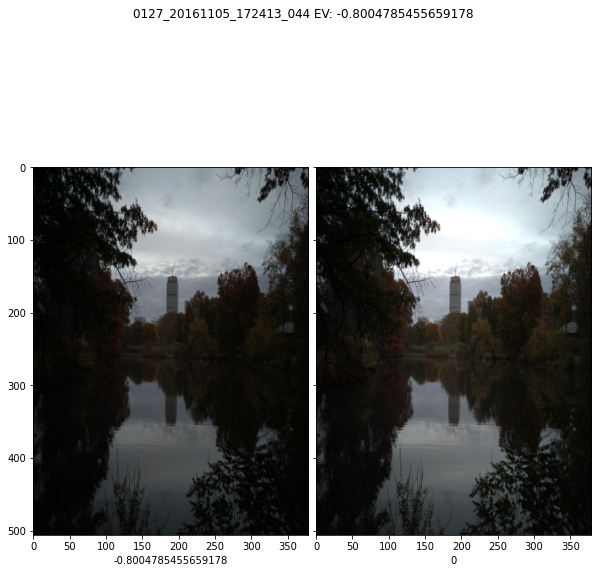

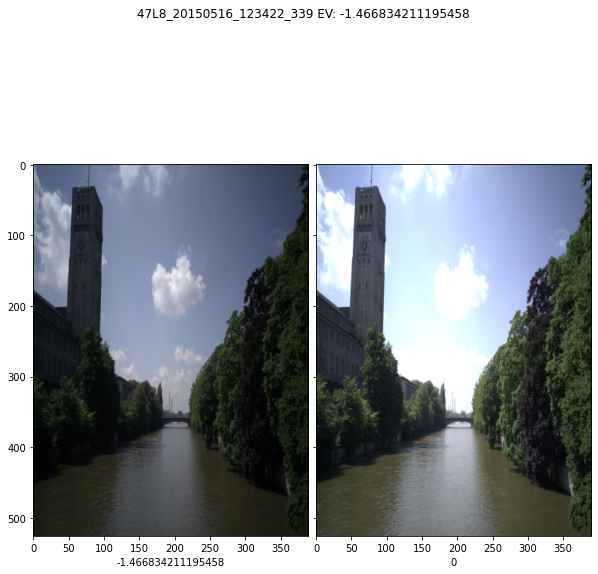

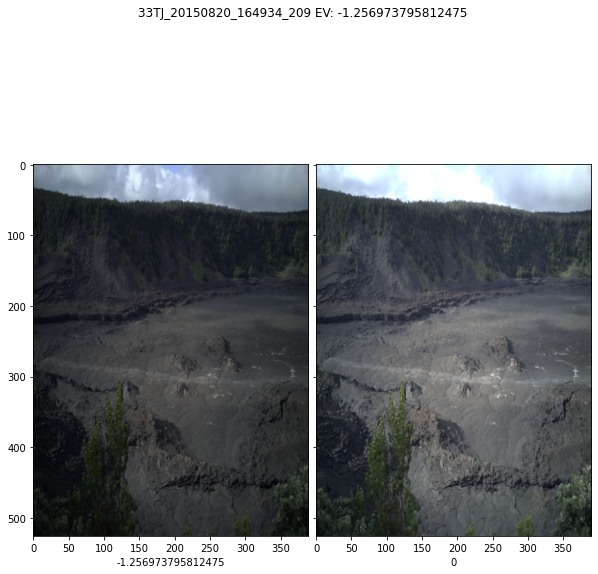

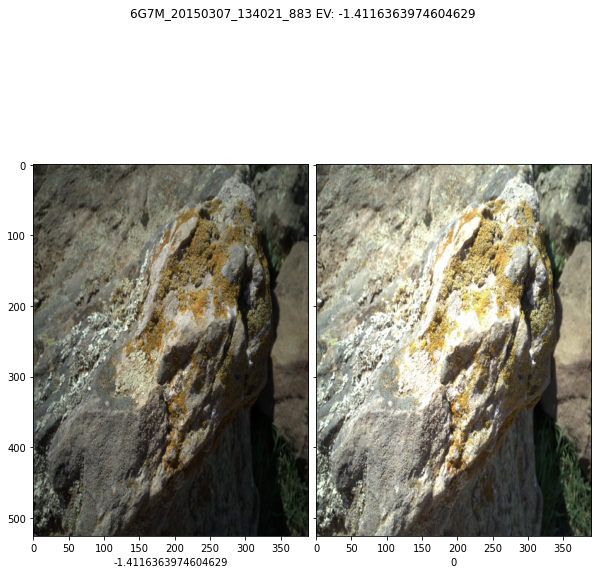

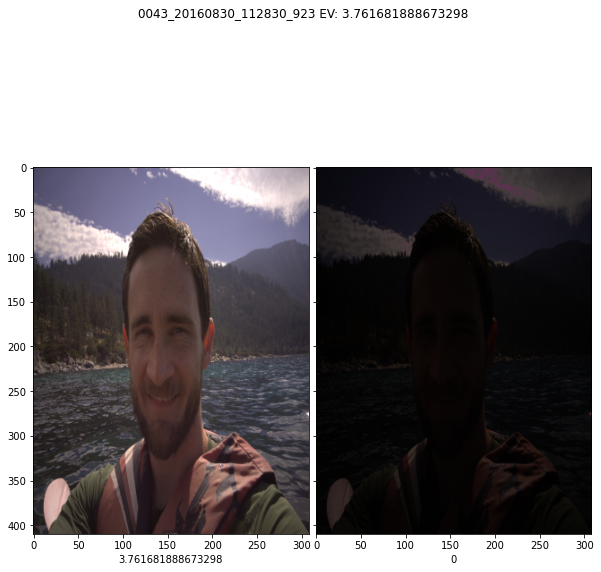

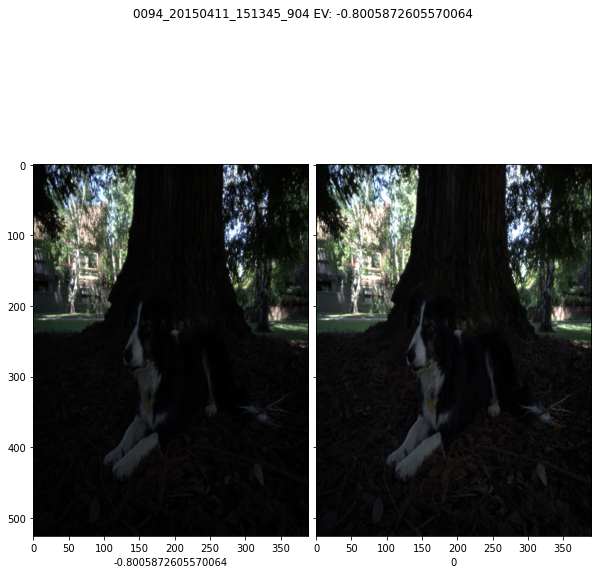

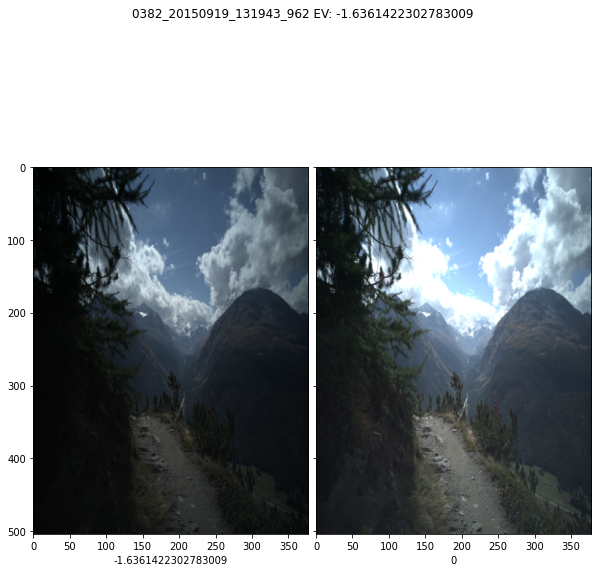

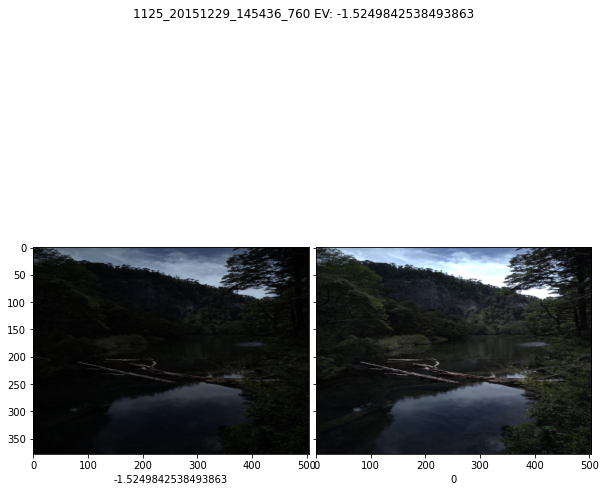

In [58]:
from dhdrnet.gen_pairs import exposures_from_raw
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import cycle
plt.tight_layout()
for ip, ev in im_sample:
    fig = plt.figure(figsize=(10,10))
    imgbase, img_ev0 = exposures_from_raw(ip, [0,-ev], for_opencv=False)
    grid = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.1)
    for ax, im, cev in zip(grid, [imgbase, img_ev0], cycle([ev,0])):
        ax.imshow(im)
        ax.set_xlabel(cev)
    fig.suptitle(f"{ip.stem} EV: {ev}")
    fig.savefig(FIGDIR/"ev_comparisons"/ f"{ip.stem}_ev_comparison.png")